In [1]:
%load_ext autoreload
%autoreload 2

from src.preprocessing import *
from src.display import *
import os, sys

os.environ["SM_FRAMEWORK"] = "tf.keras"

In [2]:
print(sys.version)

import tensorflow as tf
print(tf.__version__)

3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


2024-09-13 11:33:48.598376: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 11:33:48.600363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 11:33:48.628924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 11:33:48.629501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 11:33:49.157856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

2.12.1


In [3]:
train_folder = "data/train"
val_folder = "data/validation"

nii_files_list_train = load_nii_files(train_folder)
nii_files_list_val = load_nii_files(val_folder)

In [4]:
all_data_train = load_all_data(nii_files_list_train)
all_data_val = load_all_data(nii_files_list_val)

images_train, masks_train = separate_images_masks(all_data_train)
images_val, masks_val = separate_images_masks(all_data_val)

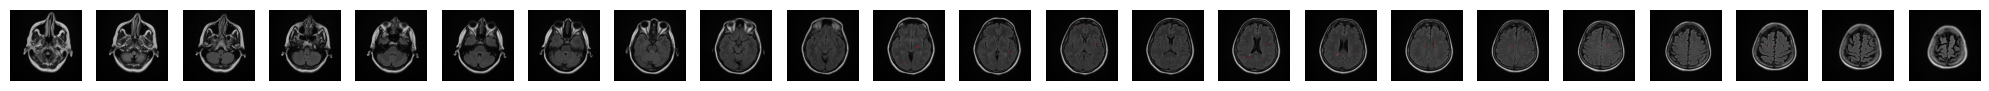

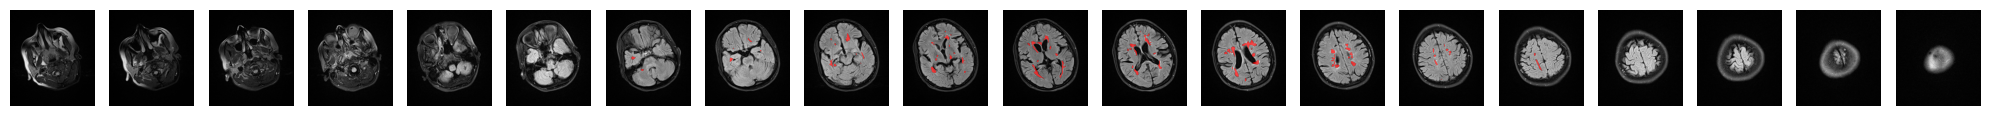

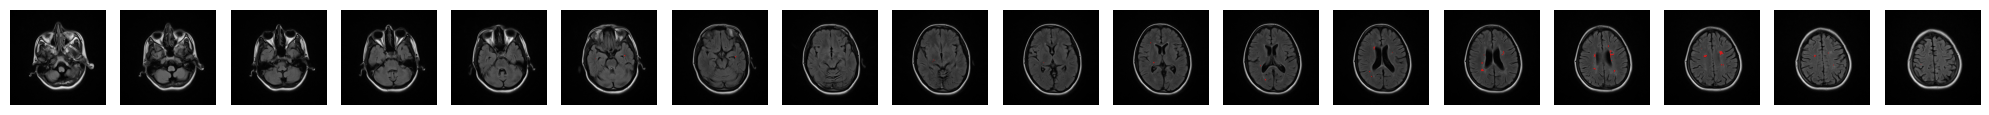

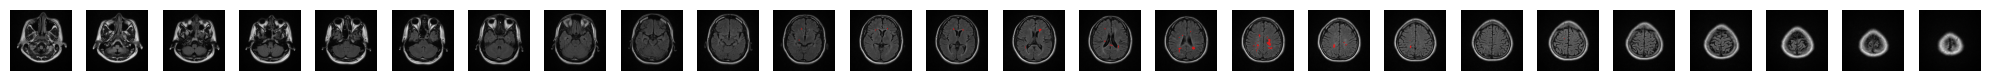

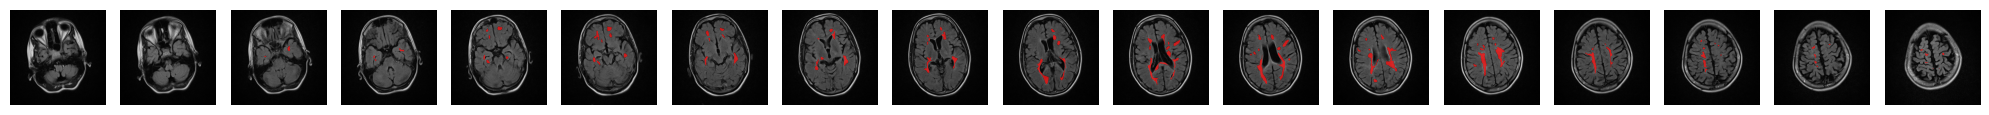

In [5]:
for i, (image, mask) in enumerate(zip(images_train[:5], masks_train[:5])):
    display_image(image, mask, rows=1)

In [6]:
resized_images_train = resize_all_images(images_train)
resized_masks_train = resize_all_images(masks_train)

resized_images_val = resize_all_images(images_val)
resized_masks_val = resize_all_images(masks_val)

# assert that the shapes are the same in mask and scan (x and y dimensions)
for image, mask in zip(resized_images_train, resized_masks_train):
    assert image.shape[:-1] == mask.shape[:-1]

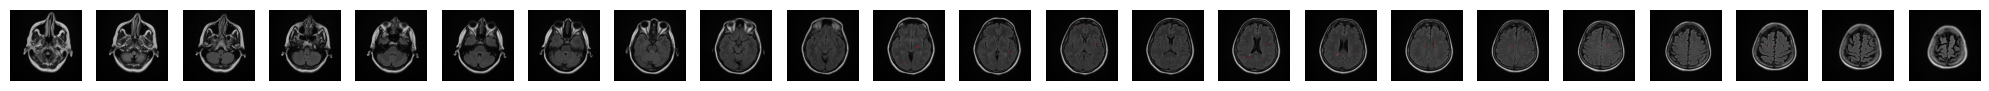

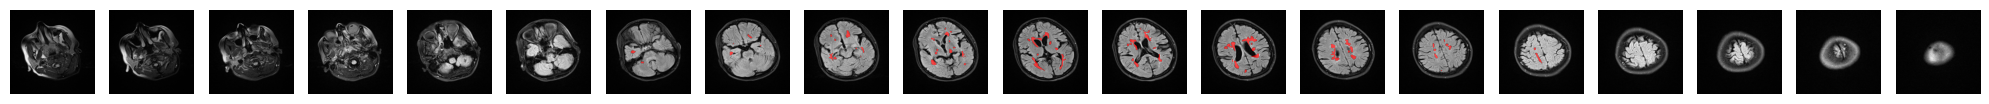

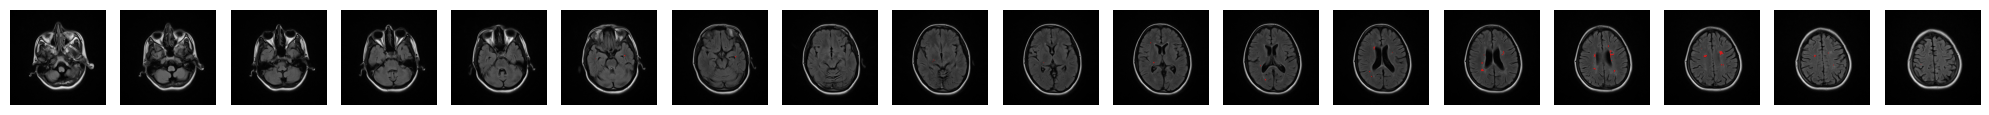

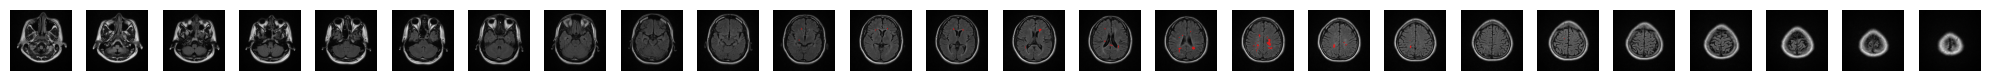

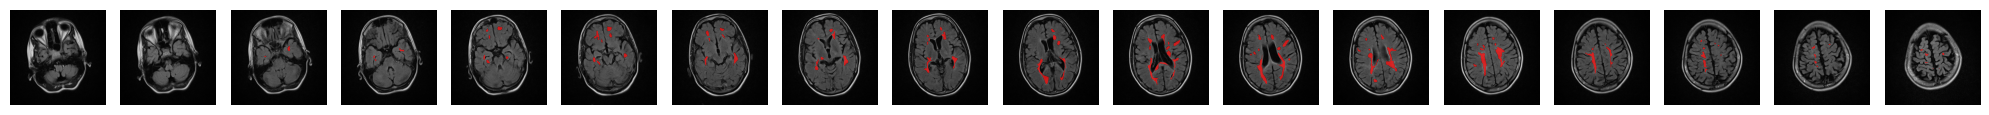

In [7]:
for i, (image, mask) in enumerate(zip(resized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [8]:
normalized_images_train = normalize_images(resized_images_train)
normalized_images_val = normalize_images(resized_images_val)

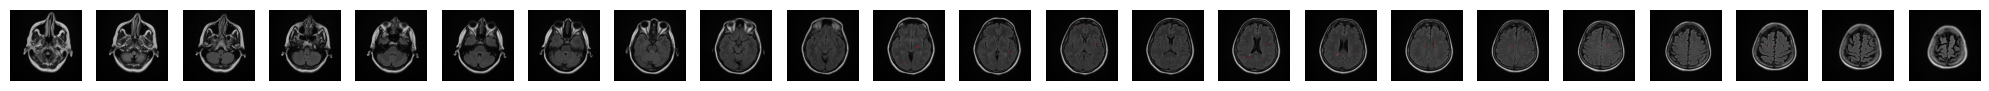

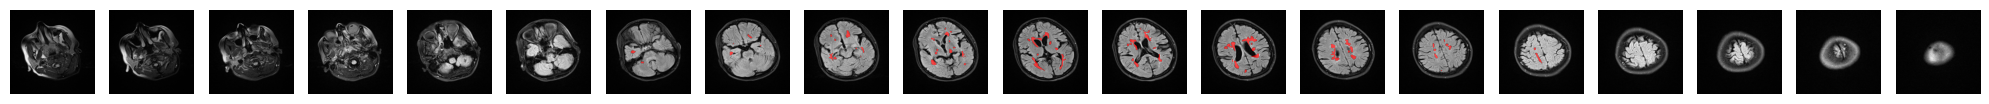

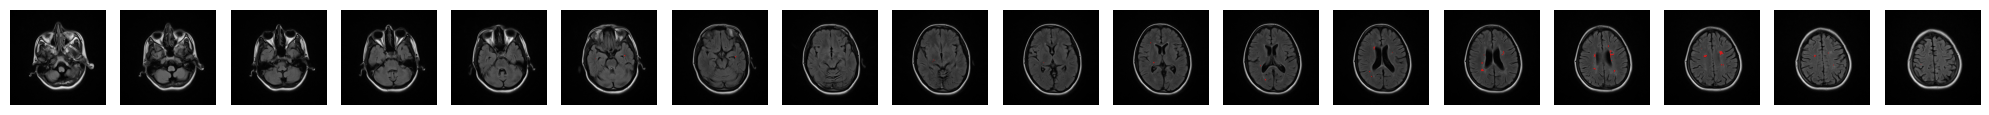

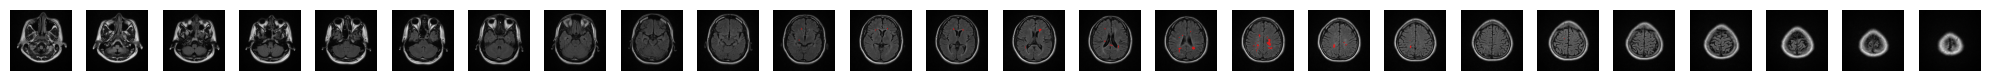

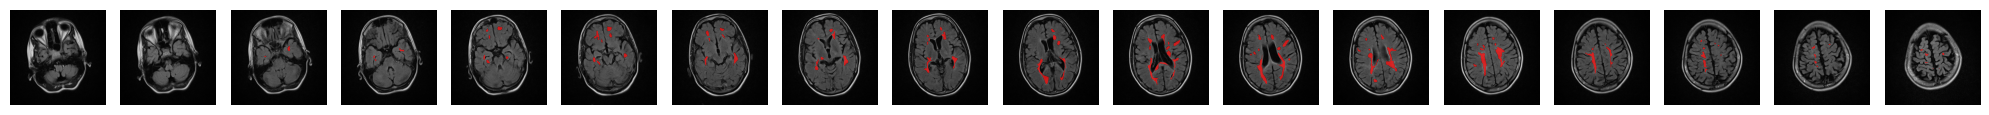

In [9]:
for i, (image, mask) in enumerate(zip(normalized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [10]:
# Keep only slices that contain lesions
filtered_images_train, filtered_masks_train = filter_slices_with_lesions(normalized_images_train, resized_masks_train)
filtered_images_val, filtered_masks_val = filter_slices_with_lesions(resized_images_val, resized_masks_val)

# Output the number of slices remaining for each scan after filtering
for i, (filtered_image_train, filtered_mask_train) in enumerate(zip(filtered_images_train, filtered_masks_train)):
    print(f"Scan {i + 1}: {filtered_image_train.shape[-1]} slices remaining, corresponding mask shape: {filtered_mask_train.shape}")

Scan 1: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 2: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 3: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 4: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 5: 16 slices remaining, corresponding mask shape: (256, 256, 16)
Scan 6: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 7: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 8: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 9: 4 slices remaining, corresponding mask shape: (256, 256, 4)
Scan 10: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 11: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 12: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 13: 19 slices remaining, corresponding mask shape: (256, 256, 19)
Scan 14: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 15: 12 slices re

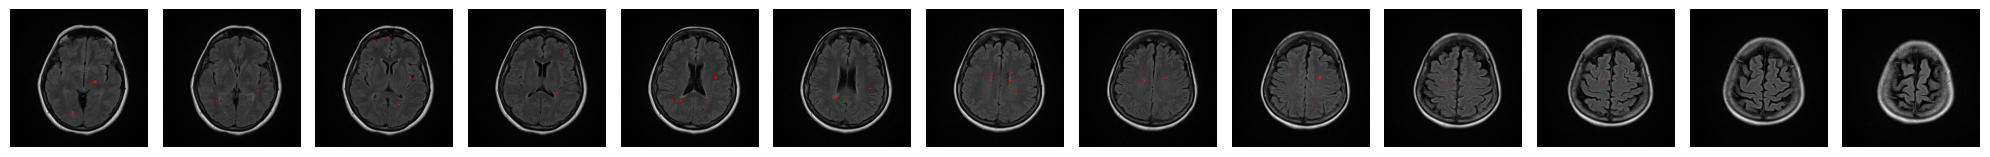

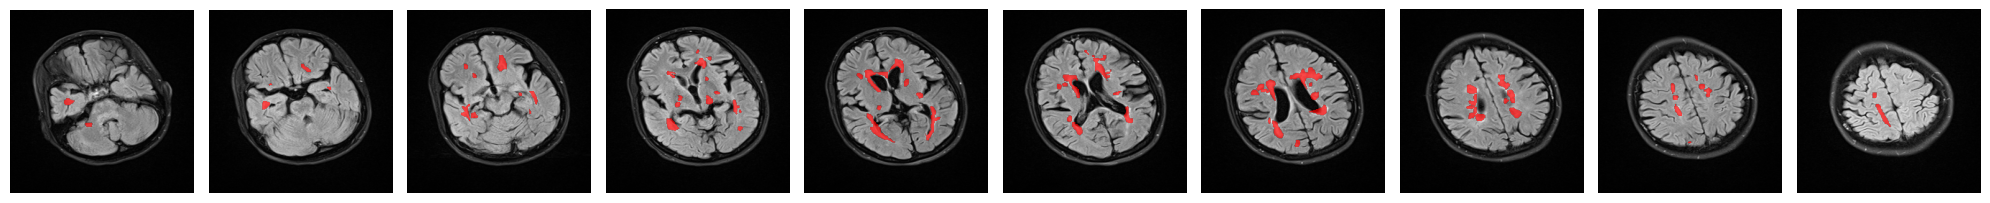

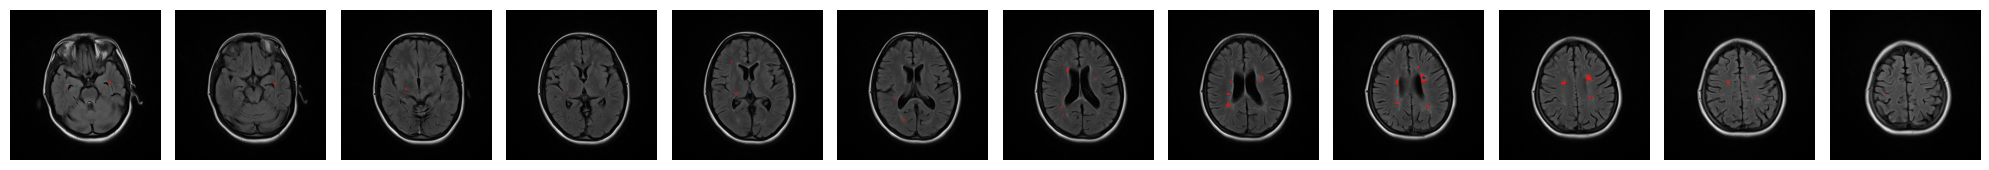

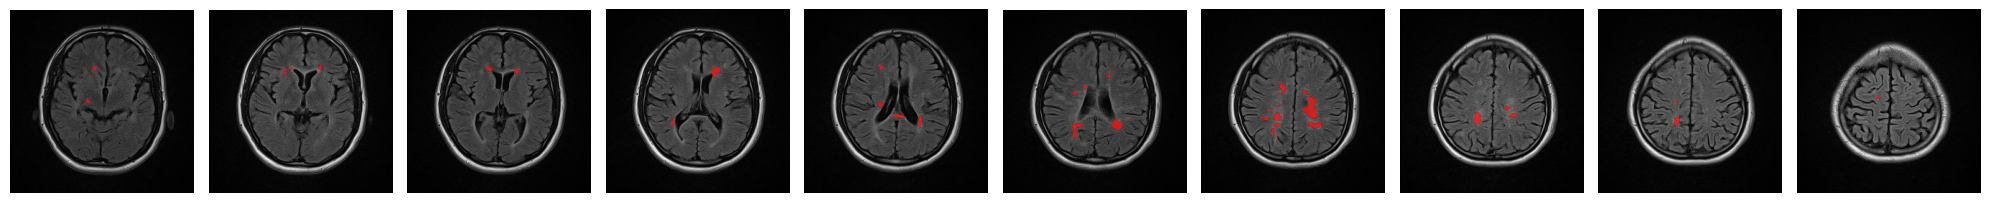

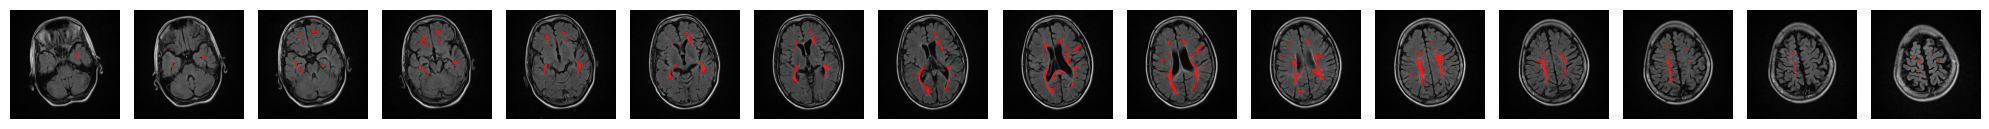

In [11]:
for i, (image, mask) in enumerate(zip(filtered_images_train[:5], filtered_masks_train[:5])):
    display_image(image, mask, rows=1)

In [12]:
# Stack 2D slices from all images
all_slices_train = stack_slices(filtered_images_train)
all_masks_train = stack_slices(filtered_masks_train)
all_slices_val = stack_slices(filtered_images_val)
all_masks_val = stack_slices(filtered_masks_val)

In [13]:
# create a data generator
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,  # Slight rotations to account for patient positioning
    width_shift_range=0.05,  # Small shifts to simulate patient movement
    height_shift_range=0.05,
    zoom_range=0.05,  # Slight zooming to account for scan variability
    horizontal_flip=True,  # Flips can help with generalization
    vertical_flip=False,  # Vertical flips are less common in medical imaging
    fill_mode='nearest',  # Fills in newly created pixels
    #brightness_range=[0.9, 1.1],  # Slight brightness variations
)


In [14]:
batch_size = 32
train_generator = datagen.flow(all_slices_train, all_masks_train, batch_size=batch_size)
val_generator = datagen.flow(all_slices_val, all_masks_val, batch_size=batch_size)

In [15]:
batch_slices, batch_masks = next(train_generator)    

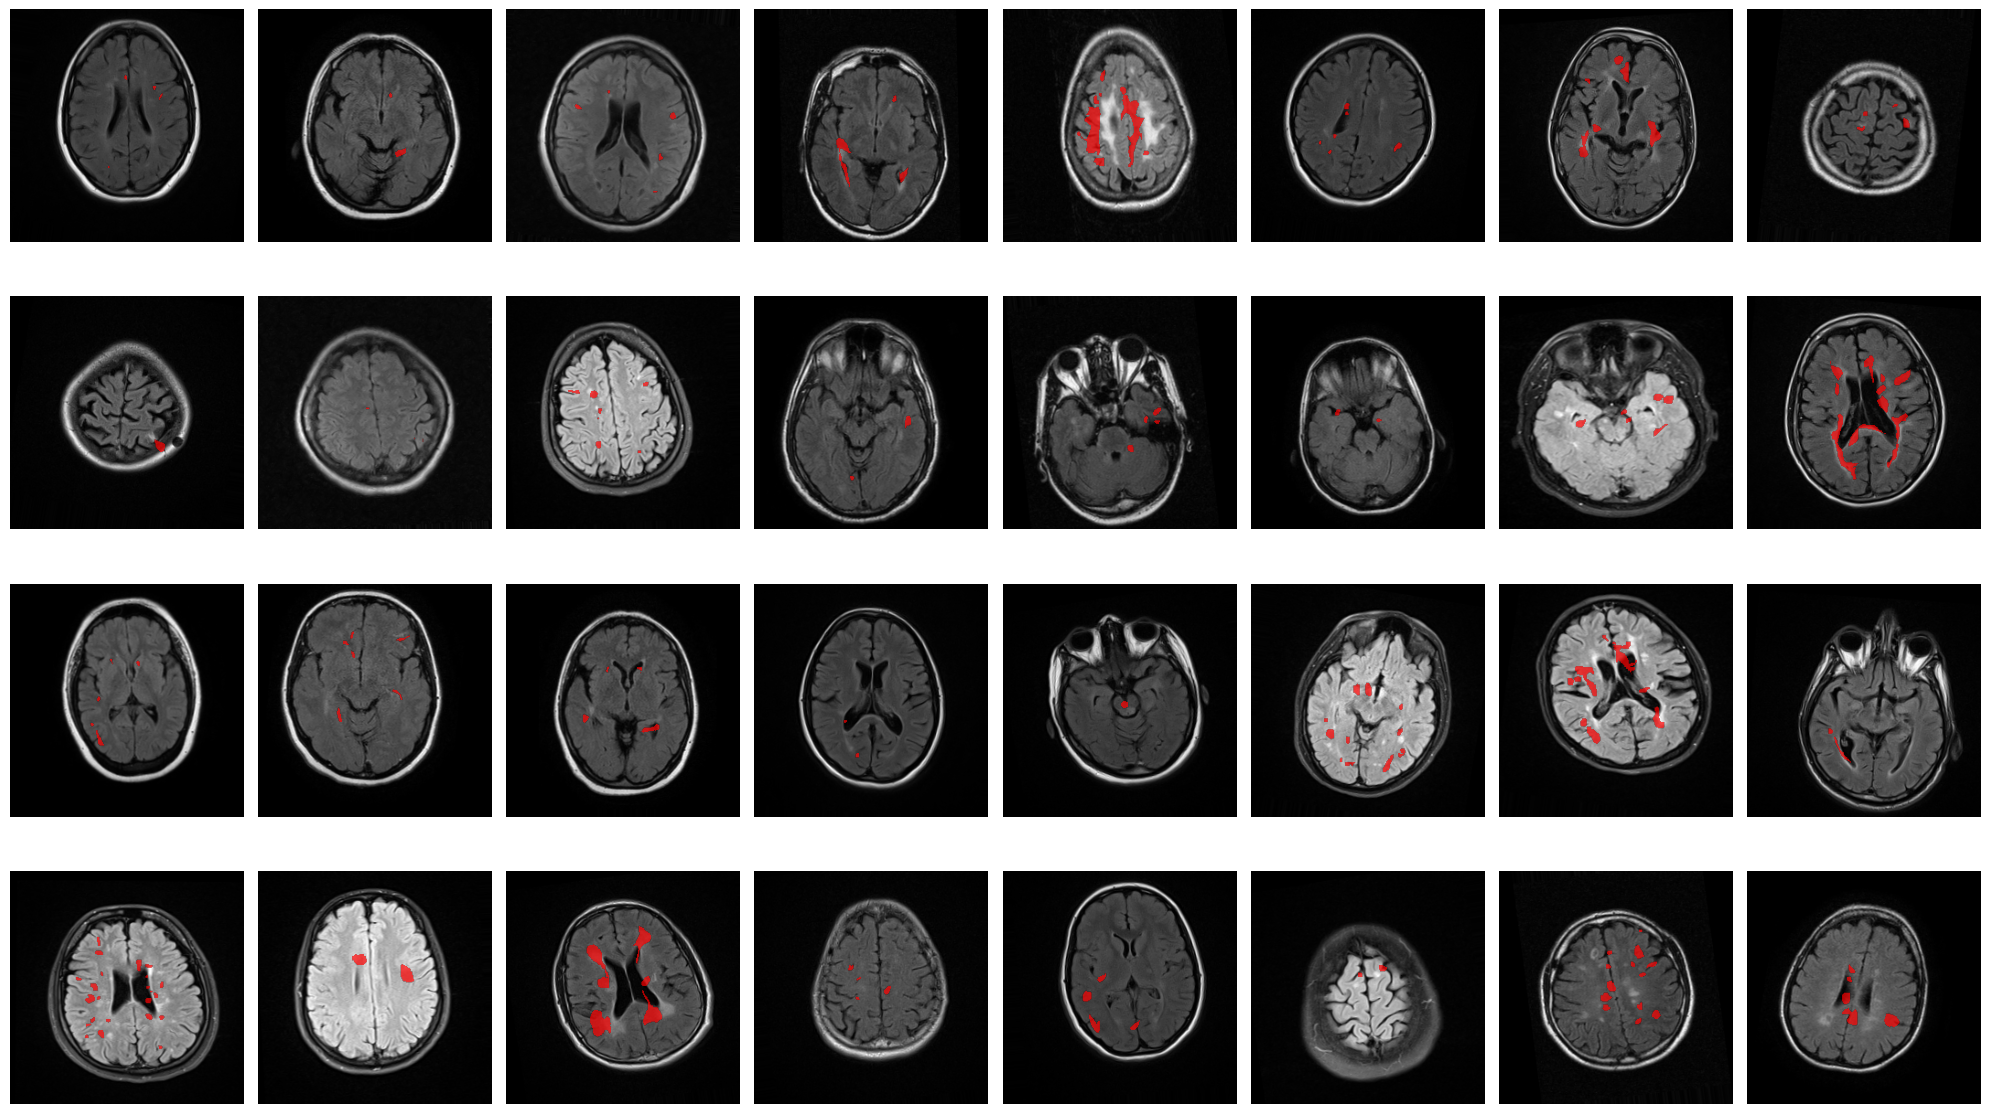

In [16]:
# display the first batch of images
display_slices(batch_slices, batch_masks, rows=4)